In [11]:
import os
import math
import sys

import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from hydra import initialize, compose


# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='../../config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.analysis import ft, stats
from mejiro.plots import plot

In [12]:
array_dir = os.path.join(array_dir, 'sample_skypy_lens')
pickle_dir = os.path.join(pickle_dir, 'pyhalo')

# Different PSFs

In [13]:
no_psf = np.load(os.path.join(array_dir, 'no_psf.npy'))
gaussian_psf = np.load(os.path.join(array_dir, 'gaussian_psf.npy'))
pandeia = np.load(os.path.join(array_dir, 'webbpsf.npy'))

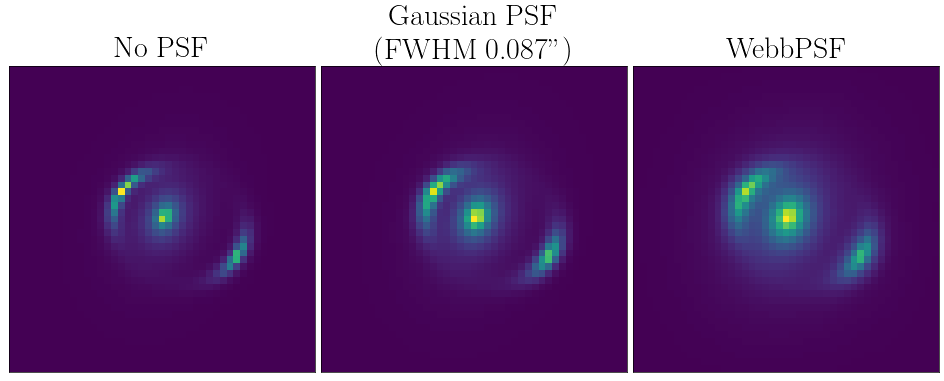

In [14]:
psf_title_list = ['No PSF', 'Gaussian PSF\n(FWHM 0.087\")', 'WebbPSF']
plot.plot_list([no_psf, gaussian_psf, pandeia], title_list=psf_title_list)

In [15]:
k, power_no_psf, num_modes = ft.twod_ft(no_psf, 4.95)
_, power_gaussian_psf, _ = ft.twod_ft(gaussian_psf, 4.95)
_, power_pandeia, _ = ft.twod_ft(pandeia, 4.95)


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds


# Substructure

In [16]:
no_cut_masses = np.load(os.path.join(pickle_dir, 'no_cut_masses.npy'))
cut_7_masses = np.load(os.path.join(pickle_dir, 'cut_7_masses.npy'))
cut_8_masses = np.load(os.path.join(pickle_dir, 'cut_8_masses.npy'))

In [17]:
no_cut_image = np.load(os.path.join(array_dir, 'substructure_no_cut.npy'))
cut_7_image = np.load(os.path.join(array_dir, 'substructure_cut_7.npy'))
cut_8_image = np.load(os.path.join(array_dir, 'substructure_cut_8.npy'))

images = [no_cut_image, cut_7_image, cut_8_image]
titles = ['substructure_no_cut', 'substructure_cut_7', 'substructure_cut_8']

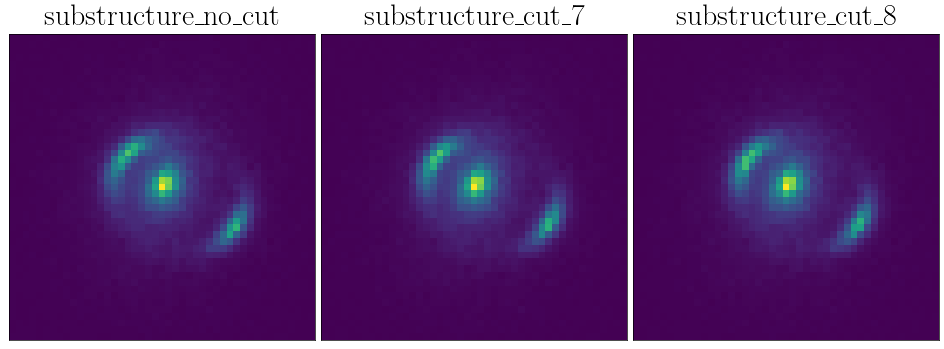

In [18]:
plot.plot_list(images, title_list=titles)

In [19]:
k, power_no_cut, num_modes = ft.twod_ft(no_cut_image, 4.95)
_, power_cut_7, _ = ft.twod_ft(cut_7_image, 4.95)
_, power_cut_8, _ = ft.twod_ft(cut_8_image, 4.95)


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds


# Plot

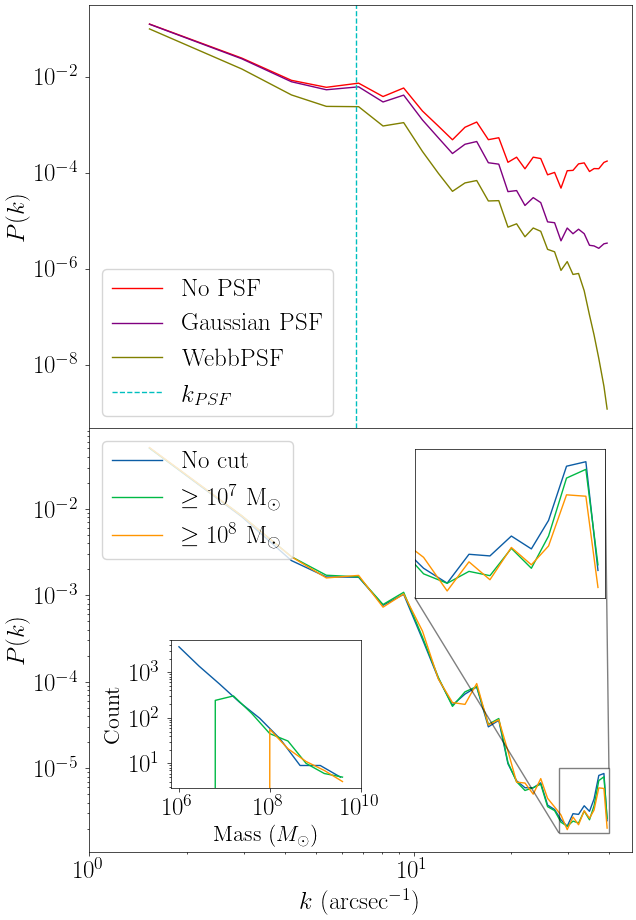

In [36]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(7, 11))

# remove vertical space between axes
fig.subplots_adjust(hspace=0)

ax[0].loglog(k, power_no_psf, label='No PSF', color='red')
ax[0].loglog(k, power_gaussian_psf, label='Gaussian PSF', color='purple')
ax[0].loglog(k, power_pandeia, label='WebbPSF', color='olive')
ax[0].axvline(1/0.151, label='$k_{PSF}$', color='c', linestyle='--')

# x1, x2, y1, y2 = 10, 40, 5 * 10 ** -5, 4 * 10 ** -3
# zoom_axes0 = ax[0].inset_axes(bounds=[0.05,0.05,0.5,0.5], xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
# zoom_axes0.loglog(k, power_no_psf, label='No PSF')
# zoom_axes0.loglog(k, power_gaussian_psf, label='Gaussian PSF')
# zoom_axes0.loglog(k, power_pandeia, label='WebbPSF')
# zoom_axes0.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labeltop=False, labelleft=False, labelright=False)
# ax[0].indicate_inset_zoom(zoom_axes0, edgecolor="black")

ax[0].set_ylabel('$P(k)$')
ax[0].legend(loc='lower left')

ax[1].loglog(k, power_no_cut, label='No cut')
ax[1].loglog(k, power_cut_7, label='$\geq 10^7$ M$_\odot$')
ax[1].loglog(k, power_cut_8, label='$\geq 10^8$ M$_\odot$')

n1, m1 = np.histogram(no_cut_masses, bins=np.logspace(6, 10, 10))
n2, m2 = np.histogram(cut_7_masses, bins=np.logspace(6, 10, 11))
n3, m3 = np.histogram(cut_8_masses, bins=np.logspace(6, 10, 11))

inset_axes = ax[1].inset_axes(bounds=[0.15,0.15,0.35,0.35])
inset_axes.loglog(m1[0:-1], n1)
inset_axes.loglog(m2[0:-1], n2)
inset_axes.loglog(m3[0:-1], n3)
# inset_axes.set_ylim(-1, 0.1)
inset_axes.set_xticks([10 ** 6, 10 ** 8, 10 ** 10])
inset_axes.set_xlabel('Mass '+r'($M_{\odot}$)', fontsize=16)
inset_axes.set_ylabel('Count', fontsize=16)

x1, x2, y1, y2 = 28, 40, 1.8 * 10 ** -6, 1 * 10 ** -5
zoom_axes = ax[1].inset_axes(bounds=[0.6,0.6,0.35,0.35], xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
zoom_axes.loglog(k, power_no_cut, label='No cut')
zoom_axes.loglog(k, power_cut_7, label='$\geq 10^7$ M$_\odot$')
zoom_axes.loglog(k, power_cut_8, label='$\geq 10^8$ M$_\odot$')
zoom_axes.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labeltop=False, labelleft=False, labelright=False)
ax[1].indicate_inset_zoom(zoom_axes, edgecolor="black")

ax[1].set_xlabel('$k$ (arcsec$^{-1}$)')
ax[1].set_xticks([10 ** 0, 10 ** 1])
ax[1].set_ylabel('$P(k)$')
ax[1].legend(loc='upper left')

plt.savefig(os.path.join(figure_dir, 'power_spectra.png'))